# Data Simulation


In [1]:
import random as rnd
import numpy as np
import math
import string
from scipy.stats import binom

## Muon Chamber Settings



In [2]:
DURATION = {
    'orbit:bx': 3564,
    'orbit': 3564*25,
    'bx': 25.,
    'tdc': 25./30
}

XCELL = 42. # cell width in mm
ZCELL = 13. # cell height in mm

TDRIFT = 15.6*DURATION['bx']  # drift time in ns
VDRIFT = XCELL*0.5 / TDRIFT   # drift velocity in mm/ns

## number of cells
NLAYERS = 8 # number of layers
NWIRES  = 8 # numbers of cells per layer
# Starting from a single cell, new columns are added alternating on the right and on the left,
# while new rows are added alternating on the bottom and on the top

## shifts
pos_shift_z  = [ZCELL*(-(NLAYERS-1-(NLAYERS%2))/2 + i) for i in range(NLAYERS)] # [..., -1.5*ZCELL, -0.5*ZCELL, 0.5*ZCELL, 1.5*ZCELL, ...]
                                                                                # If NLAYERS is odd, the additional layer in on top
is_shifted_right = [(i+1+(NLAYERS//2)%2)%2 for i in range(NLAYERS)]             # 1 if layer is shifted to the right, 0 otherwise
                                                                                # For NLAYERS=4 it is [1, 0, 1, 0]

# mappings

WIRE_MAP = {i:string.ascii_uppercase[i-1] for i in range(1, NWIRES+1)}
SIDE_MAP = {-1:'L',1:'R'}

LAYER_MAP = [-99] + [i-1 for i in range(NLAYERS, 0, -1)]

## Generate Signal Events

In [3]:
def correct_hit(psi, dx):
    ## corrections
    slope = 4
    offset = 6#4
    linear_factor = 15

    # region near the wire
    x0 = (offset+linear_factor*math.pow(math.tan(psi),1.5)) / slope

    if dx<=x0:
        # linear relation
        return offset+linear_factor*math.pow(math.tan(psi),1.5) - slope*dx
    else:
        return  0#-5*math.tan(psi)*np.sin(math.tan(psi)*4*math.pi/15*(dx-x0))

In [4]:
def generate_muon(bx0, useIdealEF=False):

    tdc0 = np.random.randint(0,30)
    angle = rnd.uniform(math.pi*1./4., math.pi*3./4.)

    m = math.tan(angle)
    xmin = -(1+(NWIRES-1)//2)*XCELL
    xmax = (0.5+NWIRES//2)*XCELL
    entry_point = rnd.uniform(xmin, xmax)
    q = - m*entry_point

    psi = math.pi/2-angle

    muon_hits = []

    wire_pattern = ''
    side_pattern = ''

    for l in range(NLAYERS):
        x = (pos_shift_z[l] - q)/m

        # apply smearing
        x += 0.25*np.random.randn()

        # find the wire
        nw = math.floor((x-xmin-is_shifted_right[l]*0.5*XCELL)/XCELL)+1

        # remove hits outside the macrocell
        if nw < 1 or nw > NWIRES: continue

        # find the distance from the wire
        dx = x - xmin - (is_shifted_right[l]+1)*0.5*XCELL - (nw-1)*XCELL

        # remove hits in the I
        if abs(dx) >= (21 - 1.4/2):
            continue

        ## apply EF dishomogeneity
        # drift time
        t = abs(dx) / VDRIFT

        if not useIdealEF:
            t -= 19.79*math.pow(math.tan(psi),2)
            t += correct_hit(abs(psi), abs(dx))

        # compute BX and TDC
        bx = t // DURATION['bx']
        dt = t % DURATION['bx']


        tdc_meas = (int(np.floor(dt/DURATION['tdc'])) + tdc0) % 30
        bx_counter = int(bx0 + bx) + (int(np.floor(dt/DURATION['tdc'])) + tdc0)//30

        wire_pattern += f"{l+1}{WIRE_MAP[nw]}"
        side_pattern += f"{SIDE_MAP[1 if dx>0 else -1]}"

        muon_hits.append({
            'layer': l + 1,
            'wire_num': nw,
            'bx': bx_counter,
            'tdc': tdc_meas,
            'label': 1 if dx>0 else -1,
            't0': bx0+tdc0/30,
            'psi': psi,
            'x0': entry_point,
        })

    # get expected eq label
    """ wire_pos, side = wire_pattern, side_pattern
    wire_nums = [int(wire_pos[i])-1 for i in range(0,len(wire_pos),2)]

    if (side[:3] in ['LLL', 'RRR']) and (len(side)==4):
        wire_pos = wire_pos[2:]
        side = side[1:]
    else:
        wire_pos = wire_pos[:6]
        side = side[:3]

    selected_pattern = f'{wire_pos}-{side}'
    eq_label = find_label_from_pattern(selected_pattern)"""

    return muon_hits, f'{wire_pattern}-{side_pattern}' #,eq_label

In [5]:
def get_event(bx0):
    valid_event_flag = False
    num_muon_hits = 0
    while not valid_event_flag:
        muon_hits, gen_pattern = generate_muon(bx0)
        if len(muon_hits) >= (NLAYERS-1):
            lat = gen_pattern.split('-')[1]
            if lat.find('LLL') == -1 and lat.find('RRR') == -1:
                valid_event_flag = True
                num_muon_hits = len(muon_hits)

    # add noise
    num_hits = len(muon_hits)

    # signal label
    signal_type = True

    return muon_hits, gen_pattern, num_muon_hits, num_hits, signal_type

In [6]:
# generate a single event at BX0=500
muon_hits, pattern, num_muon_hits, num_hits, signal = get_event(500)

print(muon_hits)
print(pattern)

[{'layer': 1, 'wire_num': 2, 'bx': 505, 'tdc': 6, 'label': -1, 't0': 500.76666666666665, 'psi': -0.1550102520886978, 'x0': -97.01855077234934}, {'layer': 2, 'wire_num': 2, 'bx': 510, 'tdc': 18, 'label': 1, 't0': 500.76666666666665, 'psi': -0.1550102520886978, 'x0': -97.01855077234934}, {'layer': 3, 'wire_num': 2, 'bx': 508, 'tdc': 4, 'label': -1, 't0': 500.76666666666665, 'psi': -0.1550102520886978, 'x0': -97.01855077234934}, {'layer': 4, 'wire_num': 2, 'bx': 507, 'tdc': 14, 'label': 1, 't0': 500.76666666666665, 'psi': -0.1550102520886978, 'x0': -97.01855077234934}, {'layer': 5, 'wire_num': 2, 'bx': 511, 'tdc': 9, 'label': -1, 't0': 500.76666666666665, 'psi': -0.1550102520886978, 'x0': -97.01855077234934}, {'layer': 6, 'wire_num': 2, 'bx': 504, 'tdc': 10, 'label': 1, 't0': 500.76666666666665, 'psi': -0.1550102520886978, 'x0': -97.01855077234934}, {'layer': 7, 'wire_num': 2, 'bx': 513, 'tdc': 27, 'label': -1, 't0': 500.76666666666665, 'psi': -0.1550102520886978, 'x0': -97.01855077234934

### Event Data Type

In [7]:
## event data structure
# ev_id
# MC (4x4):
#  - hit (bx, tdc, label)
# t0
# angle
# x0
# n_true_hits
# n_hits
# pattern

hit_dtype = np.dtype([
    ('bx', np.int16),
    ('tdc', np.int16),
    ('label', np.int8)
])

gen_event_dtype = np.dtype([
    ('id', np.int16),
    ('mc', hit_dtype, (NLAYERS,NWIRES)),
    ('t0', np.float32),
    ('angle', np.float16),
    ('x0', np.float16),
    ('n_true_hits', np.int8),
    ('n_hits', np.int8),
    ('signal', np.bool_)
])

In [8]:
# fill event structure
def hits_to_numpy(event, muon_hits, signal_type):
    for hit in muon_hits:
        layer, wire = hit['layer']-1, hit['wire_num']-1

        curr_mc = event['mc'][::-1]
        curr_mc['bx'][layer, wire] = hit['bx']
        curr_mc['tdc'][layer, wire] = hit['tdc']
        curr_mc['label'][layer, wire] = hit['label']

    event['t0'] = muon_hits[0]['t0']
    event['angle'] = muon_hits[0]['psi']
    event['x0'] = muon_hits[0]['x0']

    event['n_hits'] = np.count_nonzero(event['mc']['bx']!=-1)
    event['n_true_hits'] = np.count_nonzero(event['mc']['label']!=0)
    event['signal'] = signal_type

def numpy_to_hits(event):
    muon_hits = []

    # find hits in macrocell
    curr_mc = event['mc'][::-1]

    hits_idx = np.where(curr_mc['bx']!=-1)
    for l, w in zip(*hits_idx):
        muon_hits.append({
            'layer': l+1,
            'wire_num': w+1,
            'bx': curr_mc['bx'][l, w],
            'tdc': curr_mc['tdc'][l, w],
            'label': curr_mc['label'][l,w],
            't0': event['t0'],
            'psi': event['angle'],
            'x0': event['x0']
        })

    return muon_hits

In [9]:
import tqdm

num_events = 20000

events_arr_no_noise = np.zeros(num_events, dtype=gen_event_dtype)
events_arr_no_noise['mc']['bx'] = -1
events_arr_no_noise['mc']['tdc'] = -1

for ev_id in tqdm.tqdm(range(num_events)):
    muon_hits, pattern, num_muon_hits, num_hits, signal = get_event(500)

    events_arr_no_noise[ev_id]['id'] = ev_id
    hits_to_numpy(events_arr_no_noise[ev_id], muon_hits, signal)

100%|██████████| 20000/20000 [00:02<00:00, 6795.45it/s]


## Generate Noise


In [10]:
bx0 = 500
bx_oot = 10
noise_distributions = np.concatenate([
    np.random.triangular(bx0-bx_oot, bx0, bx0,10000),
    np.random.uniform(bx0,bx0+16,30000),
    np.random.triangular(bx0+16,bx0+16,bx0+16+bx_oot,10000)
])
cell_ineff = 0.06

def get_event_noise(bx0, noise_frac=0):
    # simulate true event
    if np.random.rand() <= 0.8:
        valid_event_flag = False
        num_muon_hits = 0
        while not valid_event_flag:
            muon_hits, gen_pattern = generate_muon(bx0)
            if len(muon_hits) >= (NLAYERS-1):
                lat = gen_pattern.split('-')[1]
                if lat.find('LLL') == -1 and lat.find('RRR') == -1:
                    valid_event_flag = True
                    num_muon_hits = len(muon_hits)

        # simulate cell inefficiency
        dead_cells = binom.rvs(num_muon_hits, cell_ineff) #if (num_muon_hits==NLAYERS) and (np.random.rand()<=0.2):
        for i in range(dead_cells):
            # remove one hit
            _ = muon_hits.pop(np.random.randint(len(muon_hits)))

        # add noise
        if np.random.rand()<noise_frac:
            # number of noise hits
            n_noise = np.random.choice([1,2,3,4], p=[0.45,0.3,0.2,0.05])
            t0 = muon_hits[0]['t0']
            angle = muon_hits[0]['psi']
            x0 = muon_hits[0]['x0']
            for _ in range(n_noise):
                layer,wire_num = np.random.randint(1,NLAYERS+1), np.random.randint(1,NWIRES+1)
                #bx = bx0+np.random.randint(-10,20)
                bx = round(np.random.choice(noise_distributions, 1)[0])
                tdc = np.random.randint(0,31)
                label = 0
                # check if it can be a real hit..
                """if bx>bx0:
                    #tdrift = (bx-bx0+tdc/30)*25
                    tdrift = (bx+tdc/30-t0)*25
                    if tdrift<TDRIFT-10:
                        dx = tdrift*VDRIFT
                        wire_pos = pos_shift_x[layer-1] + (wire_num-1)*XCELL
                        x_l = wire_pos - dx
                        x_r = wire_pos + dx

                        x_th = math.tan(angle)*pos_shift_z[layer-1]+x0

                        res_l, res_r = abs(x_l-x_th), abs(x_r-x_th)

                        if (res_l <= res_r) and (res_l<=1):
                            label = -1
                        elif (res_l >= res_r) and (res_r<=1):
                            label = +1
                        else:
                            label = 0"""

                muon_hits.append({
                        'layer': layer,
                        'wire_num': wire_num,
                        'bx': bx,
                        'tdc': tdc,
                        'label': label,
                        't0': t0,
                        'psi': angle,
                        'x0': x0
                    })

        # signal label
        signal_type = True

    # simulate noise
    else:
        muon_hits = []
        num_muon_hits = 0
        n_noise = np.random.choice([1,2,3,4], p=[0.45,0.40,0.1,0.05])
        for _ in range(n_noise):
            layer,wire_num = np.random.randint(1,NLAYERS+1), np.random.randint(1,NWIRES+1)
            t0 = bx0
            angle = -9
            x0 = -9
            bx = round(np.random.choice(noise_distributions, 1)[0])
            tdc = np.random.randint(0,31)
            label = 0
            gen_pattern = ''
            muon_hits.append({
                'layer': layer,
                'wire_num': wire_num,
                'bx': bx,
                'tdc': tdc,
                'label': label,
                't0': t0,
                'psi': angle,
                'x0': x0
            })

        # signal label
        signal_type = False

    # shuffle list
    rnd.shuffle(muon_hits)

    num_hits = len(muon_hits)

    return muon_hits, gen_pattern, num_muon_hits, num_hits, signal_type

In [11]:
## generate noisy events

num_events = 10000

events_arr = np.zeros(num_events, dtype=gen_event_dtype)

# initialize array
events_arr['mc']['bx'] = -1
events_arr['mc']['tdc'] = -1

for ev_id in tqdm.tqdm(range(num_events)):
    muon_hits, pattern, num_muon_hits, num_hits, signal = get_event_noise(500, noise_frac=0.1)

    events_arr[ev_id]['id'] = ev_id
    hits_to_numpy(events_arr[ev_id], muon_hits, signal)

100%|██████████| 10000/10000 [00:07<00:00, 1406.79it/s]


## Plot Results

In [12]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
plt.rcParams.update({'figure.max_open_warning': 0})


DURATION = {
    'orbit:bx': 3564,
    'orbit': 3564*25,
    'bx': 25.,
    'tdc': 25./30
}

NLAYERS = 8
NWIRES  = 8

XCELL = 42. # cell width in mm
ZCELL = 13. # cell height in mm

WIRE_DIAM     = 0.050 # in mm
PLANE_WIDTH   = 1.5 # in mm
IBEAM_WIDTH   = 1.3  # in mm FROM https://github.com/cms-sw/cmssw/blob/master/Geometry/DTGeometry/src/DTTopology.cc
IBEAM_WING    = 6.35  # in mm FROM https://github.com/cms-sw/cmssw/blob/master/Geometry/DTGeometry/src/DTTopology.cc

TM        = 15.5
TDRIFT    = TM*DURATION['bx']  # drift time in ns
VDRIFT    = XCELL*0.5 / TDRIFT   # drift velocity in mm/ns
VDRIFTMMBX= XCELL*0.5 / TM       # drift velocity in mm/BX
VHRATIO   = XCELL*0.5/TM/ZCELL


pos_z       = [ np.nan ] + [ZCELL*(-(NLAYERS-1-(NLAYERS%2))/2 + i) for i in range(NLAYERS)]
xmin = -(1+(NWIRES-1)//2)*XCELL
pos_x       = [ np.nan ] + [xmin + (1+s)*0.5*XCELL for s in is_shifted_right]


def plot_muon(muon_hits, bx0, x0=None, m=None, t0_scint=None, save_me=False):
    """
    Plot a list of muon hits
    Args:
        - muon_hits: list of dicts containing at least the following
                     information:
                        - hit layer
                        - hit wire (in the macrocell)
                        - hit bx
                        - hit tdc
                        - hit side (-1,0,1)
        - bx0: time pedestal for this macrocell
        - x0: local intercept of the track
        - m: tan_psi of the track
    """

    fig, ax = plt.subplots(1, 1, figsize=(XCELL*(NWIRES+1)/10,NLAYERS*ZCELL/10))

    def the_grid(the_plot):
        for ilay in range(1, NLAYERS+1):
            for iwire in range(1, NWIRES+1):
                the_plot.plot(pos_x[ilay]+XCELL*(iwire-1),pos_z[ilay],
                              marker='.',
                              markersize=2,
                              color='grey',
                              zorder=-10)
                the_plot.add_patch(
                    Rectangle((pos_x[ilay]-0.5*XCELL+XCELL*(iwire-1),
                                   pos_z[ilay]-ZCELL*0.5),
                                  XCELL,
                                  ZCELL,
                                 edgecolor='lightgrey',
                                 facecolor='None',
                             zorder=-10)
                )

    def the_planes(the_plot):
        for ilay in  range(1, NLAYERS+1):
            the_plot.add_patch(
                Rectangle((pos_x[ilay]-0.5*XCELL,
                           pos_z[ilay]-ZCELL*0.5-PLANE_WIDTH/2.),
                          NWIRES*XCELL,
                          PLANE_WIDTH,
                          facecolor='darkgrey',
                          edgecolor='None',
                          zorder=-15)
            )
            the_plot.add_patch(
                Rectangle((pos_x[ilay]-0.5*XCELL,
                           ZCELL+pos_z[ilay]-ZCELL*0.5-PLANE_WIDTH/2.),
                          NWIRES*XCELL,
                          PLANE_WIDTH,
                          facecolor='darkgrey',
                          edgecolor='None',
                          zorder=-15)
            )


    def the_ibeams(the_plot):
        for ilay in  range(1, NLAYERS+1):
            for iwire in range(1, NWIRES+1):
                the_plot.add_patch(
                    Rectangle((pos_x[ilay]-0.5*XCELL+XCELL*(iwire-1)-IBEAM_WIDTH/2,
                               pos_z[ilay]-ZCELL*0.5-PLANE_WIDTH/2.),
                              IBEAM_WIDTH,
                              ZCELL+PLANE_WIDTH,
                              facecolor='darkgrey',
                              edgecolor='None',
                              zorder=-13)
                )
                the_plot.add_patch(
                    Rectangle((XCELL+pos_x[ilay]-0.5*XCELL+XCELL*(iwire-1)-IBEAM_WIDTH/2,
                               pos_z[ilay]-ZCELL*0.5-PLANE_WIDTH/2.),
                              IBEAM_WIDTH,
                              ZCELL+PLANE_WIDTH,
                              facecolor='darkgrey',
                              edgecolor='None',
                              zorder=-13)
                )

                the_plot.add_patch(
                    Rectangle((XCELL+pos_x[ilay]-0.5*XCELL+XCELL*(iwire-1)-IBEAM_WING/2,
                               pos_z[ilay]-ZCELL*0.5+PLANE_WIDTH/2.),
                              IBEAM_WING,
                              IBEAM_WIDTH,
                              facecolor='darkgrey',
                              edgecolor='None',
                              zorder=-13)
                )
                the_plot.add_patch(
                    Rectangle((XCELL+pos_x[ilay]-0.5*XCELL+XCELL*(iwire-1)-IBEAM_WING/2,
                                  pos_z[ilay]+ZCELL*0.5-PLANE_WIDTH/2.-IBEAM_WIDTH),
                                  IBEAM_WING,
                                  IBEAM_WIDTH,
                                  facecolor='darkgrey',
                                  edgecolor='None',
                             zorder=-13)
                )

                the_plot.add_patch(
                    Rectangle((XCELL+pos_x[ilay]-0.5*XCELL+XCELL*(iwire-2)-IBEAM_WING/2,
                                  pos_z[ilay]-ZCELL*0.5+PLANE_WIDTH/2.),
                                  IBEAM_WING,
                                  IBEAM_WIDTH,
                                  facecolor='darkgrey',
                                  edgecolor='None',
                             zorder=-13)
                )
                the_plot.add_patch(
                    Rectangle((XCELL+pos_x[ilay]-0.5*XCELL+XCELL*(iwire-2)-IBEAM_WING/2,
                                  pos_z[ilay]+ZCELL*0.5-PLANE_WIDTH/2.-IBEAM_WIDTH),
                                  IBEAM_WING,
                                  IBEAM_WIDTH,
                                  facecolor='darkgrey',
                                  edgecolor='None',
                             zorder=-13)
                )



    the_grid(ax)
    the_planes(ax)
    the_ibeams(ax)

    for hit in muon_hits:
        layer, wire, bx, tdc =  hit['layer'], hit['wire_num'], hit['bx'], hit['tdc']
        plt.scatter(pos_x[layer] + (wire-1)*XCELL, pos_z[layer], color='red')

        # x left and right
        wire_pos = pos_x[layer] + (wire-1)*XCELL
        wire_z   = pos_z[layer]

        tdrift = (bx + tdc/30 - bx0)*DURATION['bx']
        x_drift = tdrift * VDRIFT
        """print("z: {}".format(wire_z))
        print("x-: {}".format(wire_pos - x_drift))
        print("x+: {}".format(wire_pos + x_drift))"""
        plt.scatter(wire_pos - x_drift, wire_z, color='green', marker="x")
        plt.scatter(wire_pos + x_drift, wire_z, color='green', marker="x")

        if t0_scint != None:
            tdrift = (bx + tdc/30 - t0_scint)*DURATION['bx']
            x_drift = tdrift * VDRIFT
            plt.scatter(wire_pos - x_drift, wire_z,  s=80, facecolors='none', edgecolors='b')
            plt.scatter(wire_pos + x_drift, wire_z,  s=80, facecolors='none', edgecolors='b')


    if (x0!=None) and (m!=None):
        bottom_x = x0 + m*(pos_z[1]-0.5*ZCELL)
        top_x    = x0 + m*(pos_z[NLAYERS]+0.5*ZCELL)

        plt.plot((bottom_x,top_x),(pos_z[1]-0.5*ZCELL,pos_z[NLAYERS]+0.5*ZCELL),'b-')

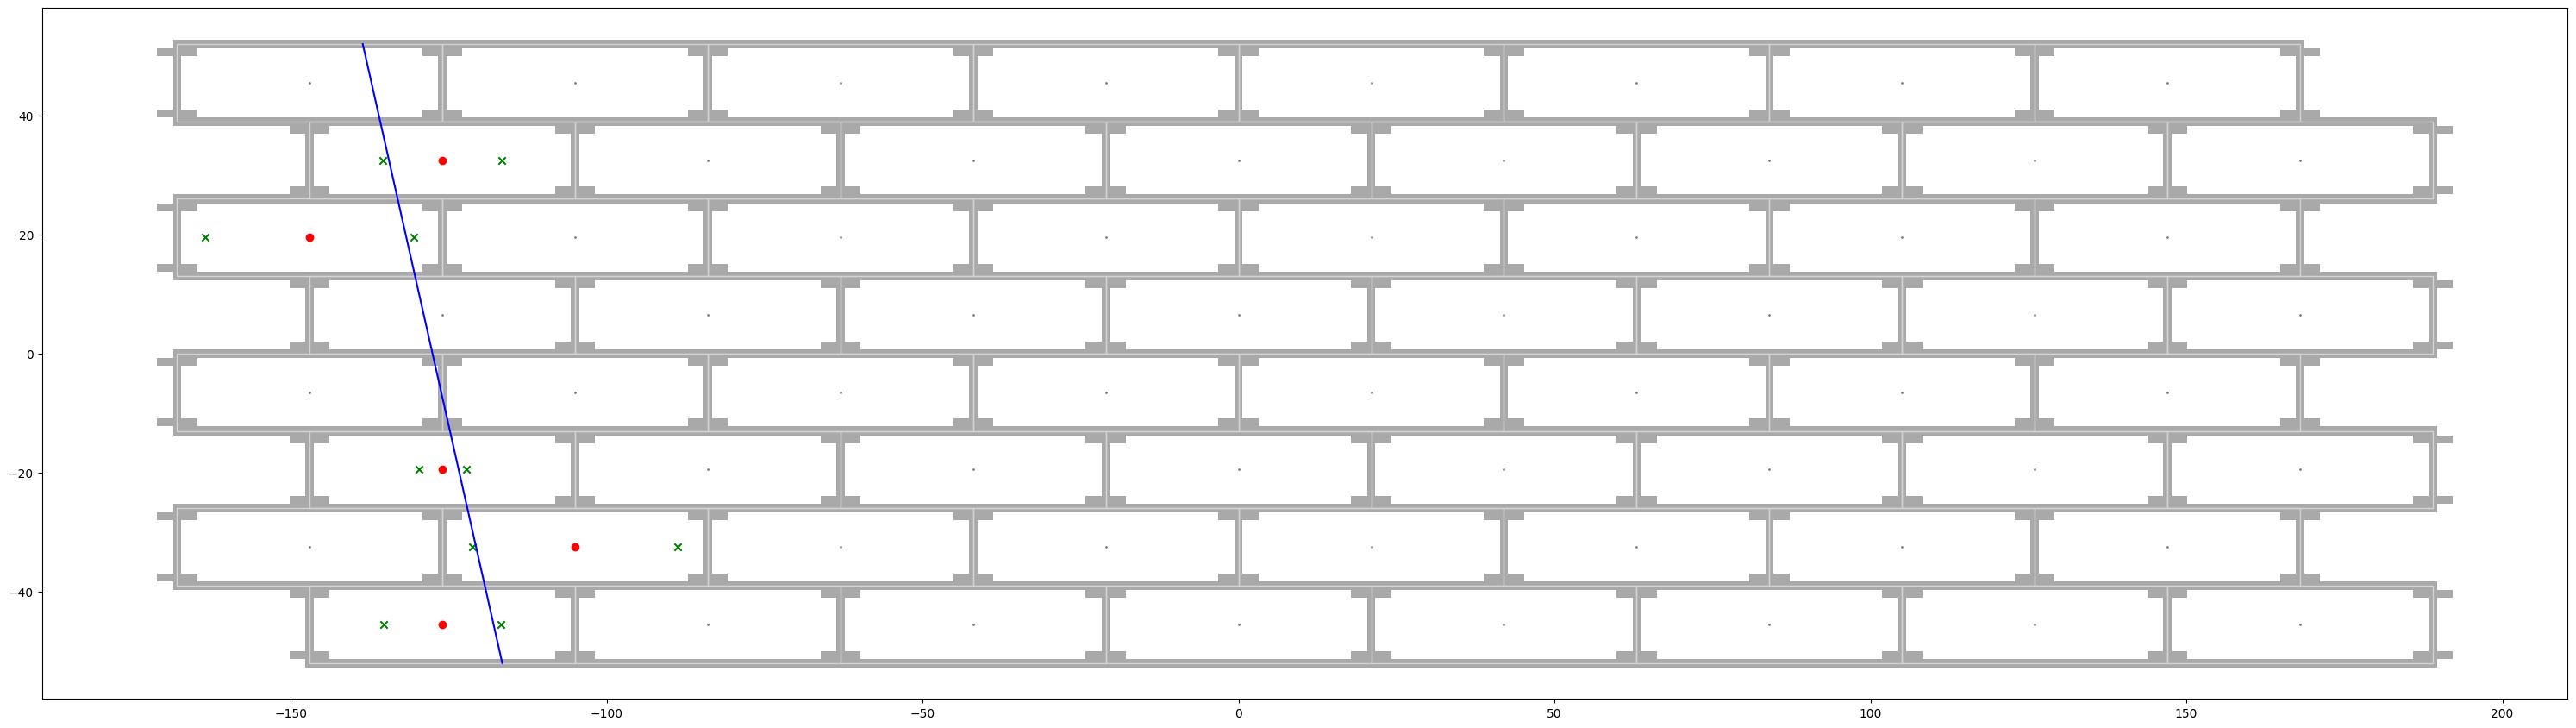

In [13]:
def plot_event(event):
    muon_hits = numpy_to_hits(event)
    m, x0 = np.tan(muon_hits[0]['psi']), muon_hits[0]['x0']
    plot_muon(muon_hits=muon_hits, bx0=500, m=m, x0=x0)

plot_event(events_arr[events_arr['n_true_hits']==5][0])

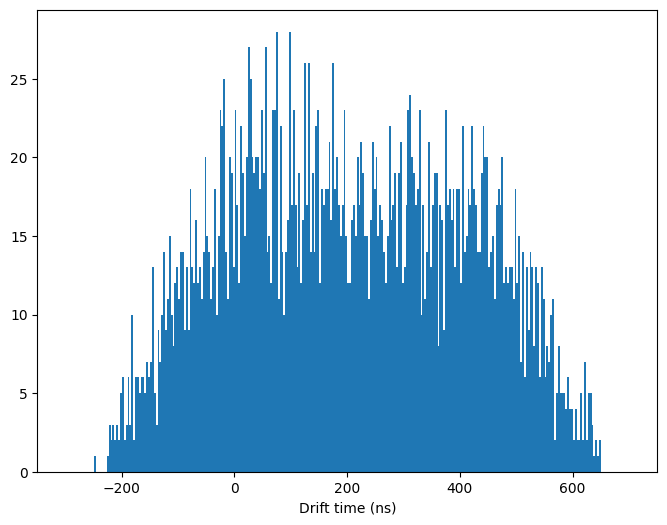

In [14]:
def get_timebox(nhits=[NLAYERS-1,NLAYERS]):
    curr_events = events_arr[np.isin(events_arr['n_true_hits'], nhits)]
    idxs = np.where((curr_events['mc']['bx']!=0))
    a = (curr_events['mc']['bx']+curr_events['mc']['tdc']/30)
    b = curr_events['t0']

    return (a-b[:,np.newaxis,np.newaxis])[idxs]*25

plt.figure(figsize=(8,6))
plt.hist(
    get_timebox([0,1,2,3,4]),
    bins=300, range=(-299.5,700.5),
    label = 'test'
)
#plt.legend()
plt.xlabel('Drift time (ns)')
plt.show()